# Neural Network for Handwritten Numbers

## Training Data
The following data is from http://yann.lecun.com/exdb/mnist/

First we read an array of training data and corresponding labels (true answers)
The goal of the neural network is to label new images similar to the training data.

In [1]:
import mnist_util
import numpy as np
np.set_printoptions(precision=3, suppress=True)
training_labels = mnist_util.read_labels('mnist/train-labels.idx1-ubyte')
training_images = mnist_util.read_images('mnist/train-images.idx3-ubyte')

Lets have a look at the first 100 training images and corresponding labels:

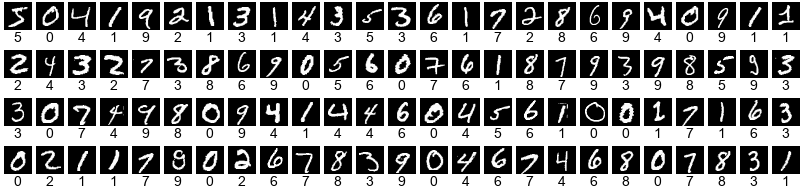

In [2]:
mnist_util.labeled_image_array(training_images[:100].reshape(100,28,28), 
                               [[str(l) for l in training_labels[:100]]])

## The neural network

We define the network with three layers:
 1. The input layer has 28  28 = 784 neurons, one for each pixel of an input image
 2. An intermediate layer of 16 neurons
 3. An output layer of 10 neurons representing the labels 0 through 9

In [3]:
import neural
nn = neural.NeuralNetwork([28*28, 16, 10])

### Preparing the data for the network
We change the input arrays so that the pixel values are a floating point number between 0 and 1. From the label we derive an output vector with exatly one element 1 and all others 0.

In [4]:
training_size, = training_labels.shape
expected_output = np.zeros((training_size, 10))
for i, label in enumerate(training_labels):
    expected_output[i][label] = 1
training_data = training_images / 255.0

### Training the network
Even though we have a dataset of 60000 images, for now we will use the first 1000 images as training data and the next 100 as testing data. (Mainly for speed reasons). With 600 iterations we can guess correctly about 90% of the training images (which the network has optimized for) and about 80% of the test data.

If you run the following cell multiple times, additional training will further improve the network.

In [5]:
import tqdm.notebook
M = 1000
for i in tqdm.notebook.trange(600):
    output = nn.train(training_data[:M], expected_output[:M])
    np.set_printoptions(precision=3, suppress=True)
    if i%100 == 99:
        test = nn.apply(training_data[1000:1100])
        loss = np.mean(np.square(expected_output[:M] - output)) 
        training_missclass = np.sum(np.argmax(output, axis=1) != training_labels[:M])
        test_missclass     = np.sum(np.argmax(test, axis=1) != training_labels[1000:1100])
        print(i+1, loss, training_missclass, test_missclass)
result = np.argmax(output, axis=1)
np.sum(result != training_labels[:M])

100 0.08849243668098478 802 78
200 0.0688326640193613 463 49
300 0.0454027378211731 269 32
400 0.030849745540550907 129 20
500 0.022258273469280908 83 18
600 0.017162994571813438 66 18



66

### Analyzing the result
The following function will help to give an overview over multiple images.
Under each image the recognized label (and if wrong also the correct label) is shown, and below that the value of the highest output neuron (giving a sense of confidence in the recognized number)

In [6]:
def result_analysis(images, output, labels):
    result = np.argmax(output, axis=1)

    # define the colors
    C_CORR = ((0,0,0),(255,255,255))
    C_ERROR = ((255,255,255), (255,0,0))
    C_MAP = [(255,128,128),(255,192,64), (255,255,64),(128,255,128),(255,255,255)]

    colors1 = [(C_CORR if w==c else C_ERROR) for w, c in zip(result, labels)]
    colors2 = [(0, C_MAP[int(4*o[w])]) for w, o in zip(result, output)]

    labels1=[(f'{w}' if w==c else f' {w} ({c}) ') for w, c in zip(result, labels)]
    labels2=[f' {o[w]:0.2f} ' for w, o in zip(result, output)]

    return mnist_util.labeled_image_array(images.reshape(images.shape[0],28,28), 
                                   [labels1, labels2], [colors1, colors2])   

First we look at the result produced on some training data. We can see that most numbers are recogized correctly with a high confidence.

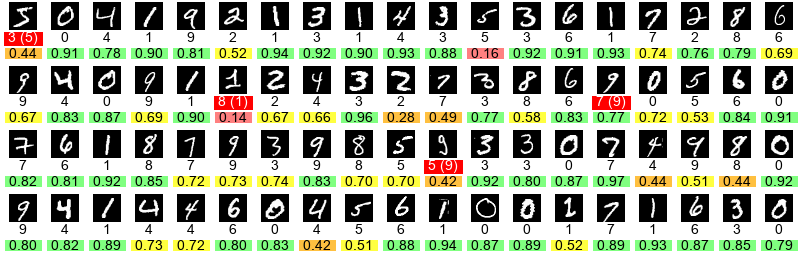

In [7]:
result_analysis(training_images[:76], output[:76], training_labels[:76])

Next lets only look at the numbers which the network failed to recognize, they also tend to have a low confidence.

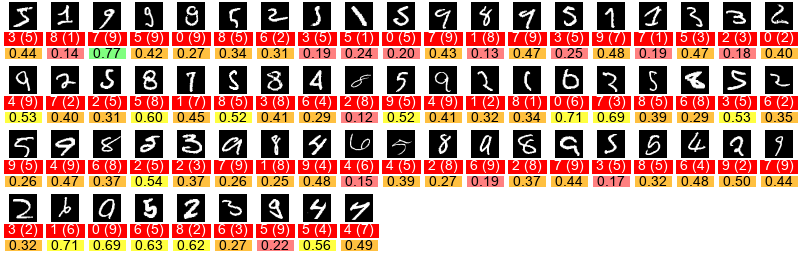

In [8]:
errors = result != training_labels[:M]
result_analysis(training_images[:M][errors], output[:M][errors], training_labels[:M][errors])

Finally we look at images which the network has not been trained on. As expected the error rate is higher than on the specifically trained for images.

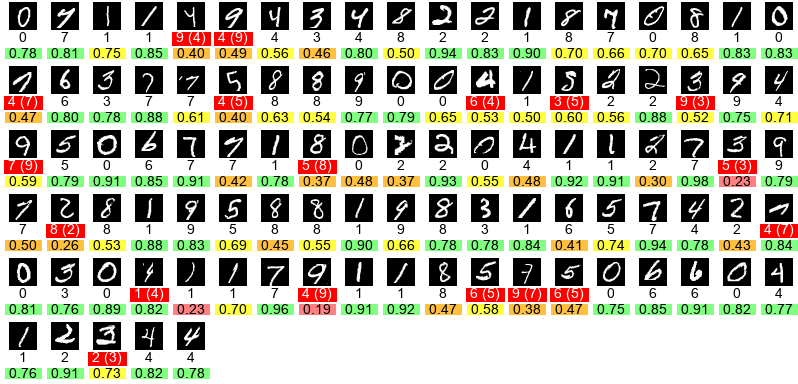

In [9]:
output_test = nn.apply(training_data[1000:1100])
result_analysis(training_images[1000:1100], output_test, training_labels[1000:1100])